In [1]:
import random
import numpy as np
import zstandard
import networkx as nx
import copy
import osmnx as ox

import random
from collections import defaultdict
import matplotlib.pyplot as plt
import os
import subprocess
import ast
import numpy as np
import sys

In [2]:
src_path = os.path.abspath(os.path.join(os.getcwd(), '../src'))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

import utils as ut

/var/folders/wn/9v3xyct512n3gh18klpzb07m0000gn/T/ipykernel_48471/1209183367.py:9: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  G = ox.graph_from_bbox(north, south, east, west, network_type='bike')


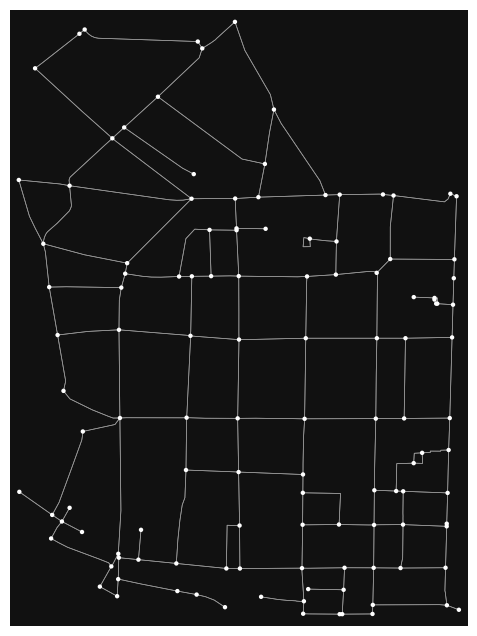

In [3]:
north, south, east, west =  43.775, 43.7698,   11.2555, 11.250

#north, south, east, west =  43.767, 43.770,   11.257, 11.252

ox.settings.bidirectional_network_types = ['walk', 'bike']

G = ox.graph_from_bbox(north, south, east, west, network_type='bike')


fig, ax = ox.plot_graph(G, node_size=10, edge_linewidth=0.5)

g = ox.utils_graph.convert.to_digraph(G, weight='length')


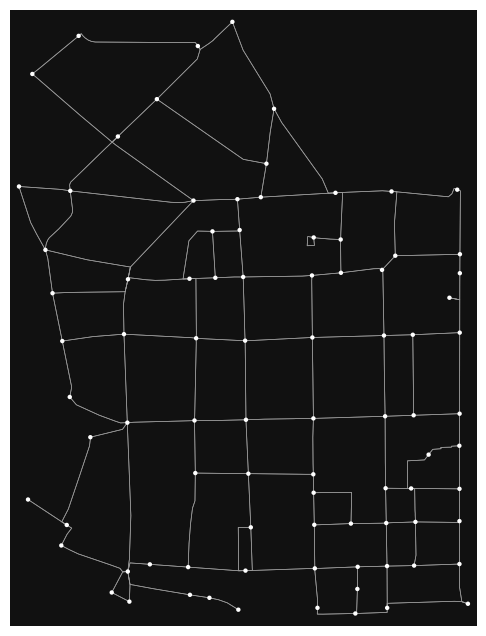

In [4]:
G_proj = ox.projection.project_graph(G)
ints = ox.simplification.consolidate_intersections(
    G_proj, rebuild_graph=False, tolerance=8, dead_ends=False
)

G = ox.simplification.consolidate_intersections(
    G_proj, rebuild_graph=True, tolerance=8, dead_ends=False
)





fig, ax = ox.plot_graph(G, node_size=10, edge_linewidth=0.5)

g = ox.utils_graph.convert.to_digraph(G, weight='length')

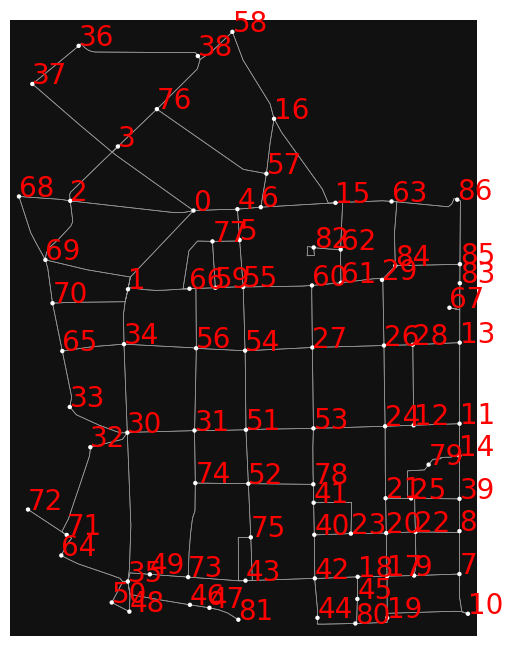

In [5]:
# Plot the graph
fig, ax = ox.plot_graph(G, node_size=10, edge_linewidth=0.5, show=False, close=False)

# Annotate each node with its ID
for node, data in G.nodes(data=True):
    x, y = data['x'], data['y']
    ax.text(x, y, str(node), fontsize=20, color='red')

plt.show()

In [6]:
latitude, longitude = 43.773220191234934, 11.256931729892534 #duomo cupola
duomo = ox.distance.nearest_nodes(G, X=longitude, Y=latitude)

latitude, longitude = 43.76834829925962, 11.253392361994969 #ponte vecchio
latitude, longitude = 43.76850539578035, 11.253554808530508
latitude, longitude = 43.76852634214558, 11.253463646990337
ponte = ox.distance.nearest_nodes(G, X=longitude, Y=latitude)

latitude, longitude = 43.76982383598039, 11.255645235398426 #piazza della signoria
latitude, longitude = 43.76988569269107, 11.256681942197826
signoria = ox.distance.nearest_nodes(G, X=longitude, Y=latitude)


latitude, longitude = 43.77147957736075, 11.252086010843929 #palazzo strozzi
strozzi = ox.distance.nearest_nodes(G, X=longitude, Y=latitude)

latitude, longitude = 43.772927020654826, 11.254557637024302 #battistero
battistero = ox.distance.nearest_nodes(G, X=longitude, Y=latitude)

latitude, longitude = 43.76996162207744, 11.25424340140461 #porcellino
porcellino = ox.distance.nearest_nodes(G, X=longitude, Y=latitude)

latitude, longitude = 43.773647184461915, 11.250125004174826 #smn piazza
smn = ox.distance.nearest_nodes(G, X=longitude, Y=latitude)

latitude, longitude = 43.76786977161437, 11.255330051880346 #uffizi
latitude, longitude = 43.76850838811869, 11.255564506120638
uffizi = ox.distance.nearest_nodes(G, X=longitude, Y=latitude)

latitude, longitude = 43.77025701124436, 11.257847555911075 #bargello
bargello = ox.distance.nearest_nodes(G, X=longitude, Y=latitude)

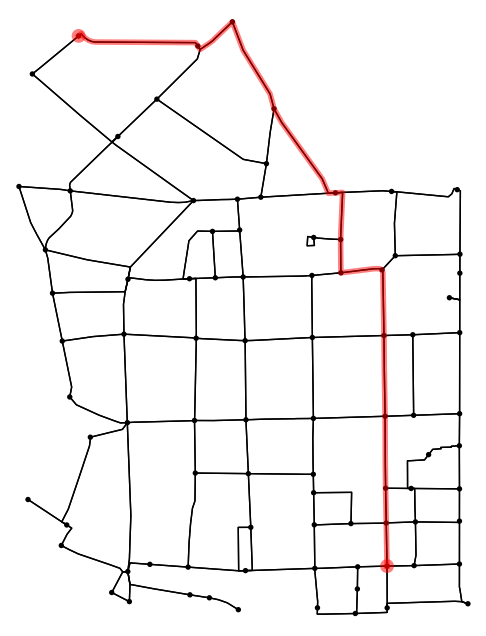

In [7]:
orig_node,dest_node =   36, 17 # smn,uffizi
#orig_node,dest_node = smn,uffizi
route = nx.shortest_path(g, orig_node, dest_node, weight='length',method='dijkstra')
fig, ax = ox.plot_graph_route(G, route, bgcolor='white', edge_color='black', node_color='black')


In [8]:
nx.shortest_path(g, orig_node, dest_node, weight='length',method='dijkstra')

[36, 38, 58, 16, 15, 62, 61, 29, 26, 24, 21, 20, 17]

In [9]:
folder_path = "../../kspwlo-master/"
os.chdir(folder_path)
wgt = 'length'
node_map = ut.save_graph_to_gr(g, 'tmp.gr', source=orig_node, target=dest_node,weight = wgt)
EKSP_node_map = ut.save_graph_to_gr_EKSP(g, 'tmp_EKSP.gr', source=orig_node, target=dest_node,weight = wgt)


In [10]:
with open('tmpQ.txt', 'w') as file:
    file.write(f"{EKSP_node_map[orig_node]} {EKSP_node_map[dest_node]}\n")

In [11]:
dag = ut.get_dag(g, orig_node, dest_node, weight=wgt)

In [12]:
len(dag.nodes())

49

In [13]:
%%time
dag = ut.get_dag(g, orig_node, dest_node, weight=wgt)
K, alpha, model, result = ut.iterative_solver(dag, orig_node, dest_node) #LP solver, alpha are the satisf. probs
final = ut.compute_probabilities_and_expectations(dag, result, dest_node) 
LP_dag = final['dag']
dag = G.subgraph(dag.nodes())

Set parameter Username
Academic license - for non-commercial use only - expires 2026-02-24
CPU times: user 60.5 ms, sys: 2.46 ms, total: 63 ms
Wall time: 63.7 ms


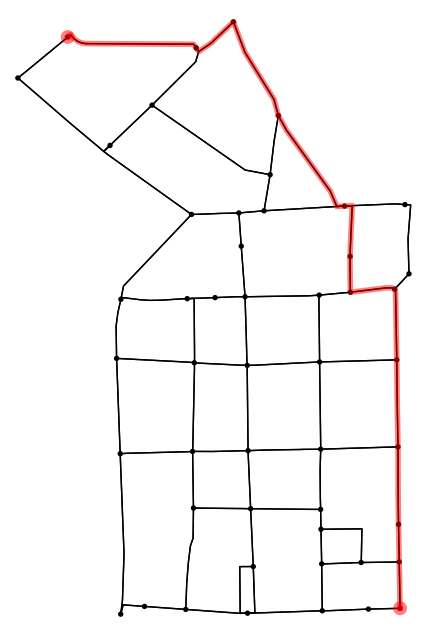

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [14]:
ox.plot_graph_route(dag, route, bgcolor='white', edge_color='black', node_color='black')


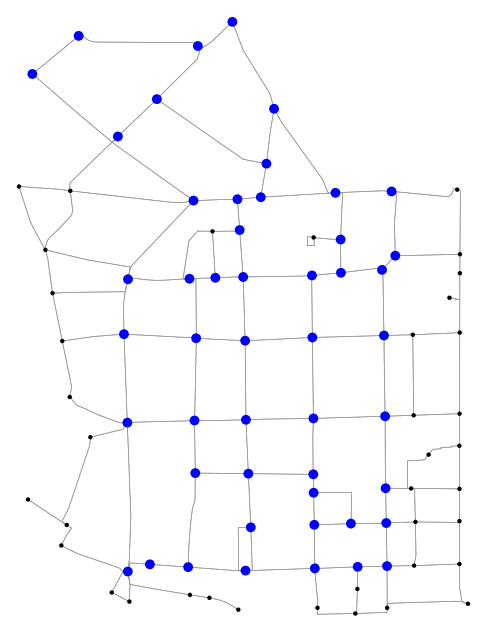

In [15]:
node_colors = ["blue" if node in dag.nodes() else "black" for node in G.nodes()]
node_sizes = [50 if node in dag.nodes() else 10 for node in G.nodes()]
fig, ax = ox.plot_graph(
    G, 
    node_color=node_colors,
    node_size=node_sizes,           # Adjust node size as needed
    edge_linewidth=0.5,     # Adjust edge linewidth as needed
    bgcolor="white"         # Background color
)

In [16]:
fair_fp = ut.sample_k_FP(LP_dag, orig_node, dest_node, 200)

In [17]:
distinct_paths = {tuple(path) for path in fair_fp}

num_distinct_paths = len(distinct_paths)

print("Number of distinct paths:", num_distinct_paths)

Number of distinct paths: 25


In [18]:
path_counts = {}
for path in fair_fp:
    path_tuple = tuple(path)  # Convert the path to a tuple for hashing
    if path_tuple in path_counts:
        path_counts[path_tuple] += 1
    else:
        path_counts[path_tuple] = 1
path_counts


{(36, 37, 3, 0, 1, 66, 59, 55, 54, 51, 52, 75, 43, 42, 18, 17): 11,
 (36, 38, 58, 16, 15, 63, 84, 29, 26, 24, 21, 20, 17): 17,
 (36, 38, 76, 3, 0, 1, 66, 56, 31, 74, 73, 43, 42, 18, 17): 2,
 (36, 38, 58, 16, 15, 62, 61, 29, 26, 24, 21, 20, 17): 18,
 (36, 38, 76, 57, 6, 15, 62, 61, 29, 26, 24, 21, 20, 17): 14,
 (36, 37, 3, 0, 1, 66, 56, 31, 74, 52, 75, 43, 42, 18, 17): 6,
 (36, 37, 3, 0, 4, 5, 55, 60, 27, 53, 78, 41, 40, 23, 20, 17): 15,
 (36, 37, 3, 0, 4, 5, 55, 54, 51, 52, 75, 43, 42, 18, 17): 8,
 (36, 38, 76, 3, 0, 1, 34, 30, 35, 49, 73, 43, 42, 18, 17): 18,
 (36, 38, 76, 3, 0, 1, 66, 59, 55, 60, 27, 53, 78, 41, 40, 23, 20, 17): 9,
 (36, 38, 76, 57, 6, 15, 63, 84, 29, 26, 24, 21, 20, 17): 17,
 (36, 37, 3, 0, 4, 5, 55, 54, 51, 53, 78, 41, 40, 23, 20, 17): 5,
 (36, 37, 3, 0, 1, 34, 30, 35, 49, 73, 43, 42, 18, 17): 12,
 (36, 37, 3, 0, 1, 66, 59, 55, 60, 27, 53, 78, 41, 40, 23, 20, 17): 10,
 (36, 38, 76, 3, 0, 1, 66, 59, 55, 54, 51, 53, 78, 41, 40, 23, 20, 17): 4,
 (36, 38, 76, 3, 0, 1, 

In [19]:
len(list(distinct_paths)[0])

15

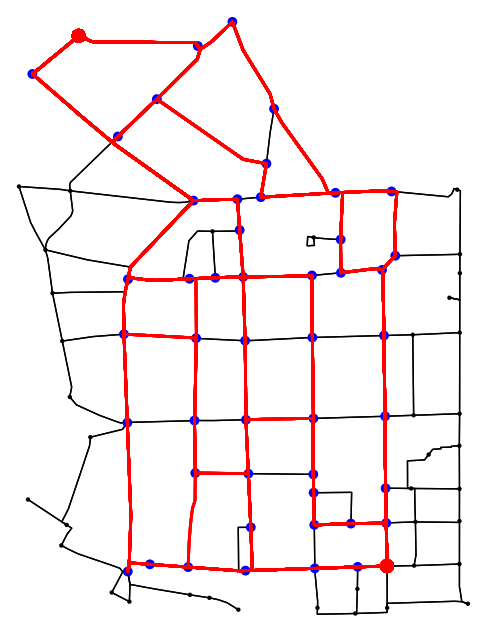

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [20]:
ox.plot_graph_routes(G, fair_fp , route_linewidths=2, node_size=node_sizes, bgcolor='white', edge_color='black', node_color=node_colors,)

In [21]:
dag_nodes = list(dag.nodes())
#node_mapping = {node: idx + 1 for idx, node in enumerate(dag_nodes)}

def compute_new_indices(dag, orig_node):
    # Step 1: Compute shortest path distances from orig_node
    distances = nx.shortest_path_length(dag, source=orig_node, weight='weight')
    
    # Step 2: Sort nodes by distance, preserving order in dag_nodes for ties
    dag_nodes = list(dag.nodes())
    sorted_nodes = sorted(dag_nodes, key=lambda node: (distances.get(node, float('inf')), dag_nodes.index(node)))
    
    # Step 3: Create a new mapping for the sorted nodes
    node_mapping = {node: idx + 1 for idx, node in enumerate(sorted_nodes)}
    
    return node_mapping

node_mapping = compute_new_indices(dag, orig_node)

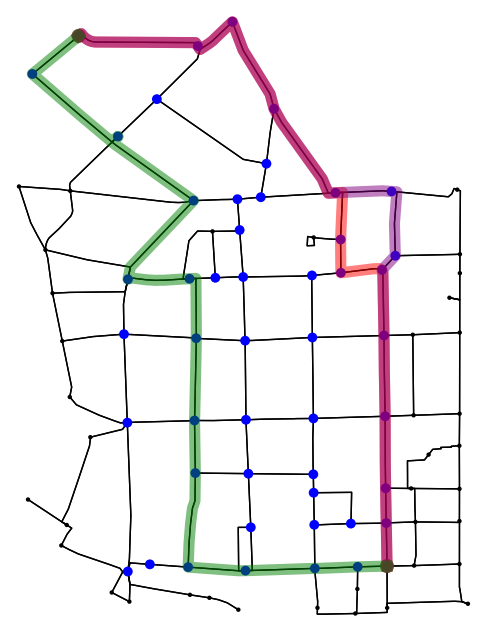

In [22]:
# Assume most_probable_path is the tuple representing the most probable path

sorted_routes = sorted(path_counts.items(), key=lambda x: x[1], reverse=True)  # Sort by frequency
all_routes = [list(route) for route, _ in sorted_routes]  


# Assign colors to the routes
route_colors = []
for route in all_routes:
    if route == all_routes[0]:  # Check if the route matches the most probable path
        route_colors.append('red')  # Highlight the most probable route in red
    elif route == all_routes[-1]:  
        route_colors.append('green') 
    elif route == all_routes[2]:  
        route_colors.append('purple') 
    else:
        route_colors.append('none')  

# Plot the graph
fig, ax = ox.plot_graph_routes(
    G, 
    all_routes, 
    route_linewidths=8, 
    route_colors=route_colors,  # Updated route colors
    node_size=node_sizes, 
    bgcolor='white', 
    edge_color='black', 
    node_color=node_colors, 
    show=False,
    close=False,
)



/Users/antonioferrara/anaconda3/lib/python3.11/site-packages/osmnx/plot.py:327: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, s=orig_dest_size, c=route_color, alpha=route_alpha, edgecolor="none")


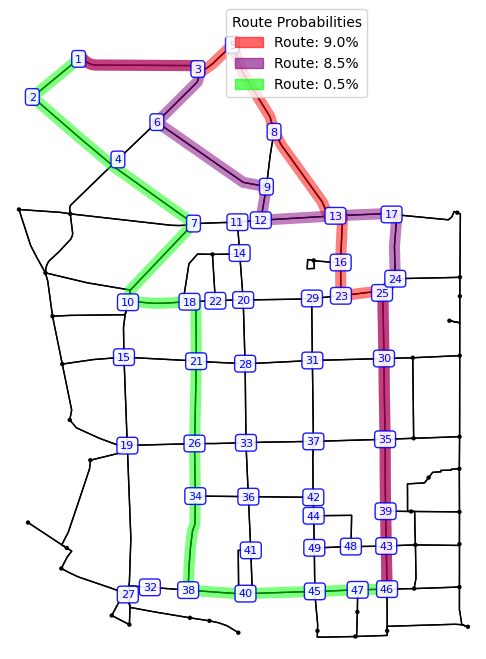

In [23]:
import matplotlib.patches as mpatches

# Start from your code
sorted_routes = sorted(path_counts.items(), key=lambda x: x[1], reverse=True)  # Sort by frequency
all_routes = [list(route) for route, _ in sorted_routes]  

# Assign colors to the routes
route_colors = []
for route in all_routes:
    if route == all_routes[0]:  # Check if the route matches the first route
        route_colors.append((1, 0, 0))  # Highlight the first route in red
    elif route == all_routes[-1]:  # Check if the route matches the last route
        route_colors.append((0, 1, 0))  # Highlight the last route in green
    elif route == all_routes[3]:  # Check if the route matches the third route
        route_colors.append((0.5, 0, 0.5))  # Highlight the third route in purple
    else:
        route_colors.append('none')  # Make other routes invisible

# Compute probabilities for all_routes
total_count = sum(count for _, count in sorted_routes)
route_probabilities = {tuple(route): (count / total_count) * 100 for route, count in sorted_routes}

# Create a legend for the specified routes
legend_patches = []
alpha_value = 0.6
for color, route in zip([(1, 0, 0, alpha_value), (0.5, 0, 0.5, alpha_value), (0, 1, 0, alpha_value)], 
                        [all_routes[0], all_routes[3], all_routes[-1]]):
    prob = route_probabilities.get(tuple(route), 0)
    legend_patches.append(mpatches.Patch(color=color, label=f'Route: {prob:.1f}%'))


# Plot the graph
fig, ax = ox.plot_graph_routes(
    G, 
    all_routes, 
    route_linewidths=8, 
    route_colors=route_colors, 
    node_size=node_sizes, 
    bgcolor='white', 
    edge_color='black', 
    node_color=node_colors, 
    show=False,
    close=False,
)

# Annotate the node numbers
for node in dag_nodes:
    x, y = G.nodes[node]['x'], G.nodes[node]['y']  # Get node coordinates
    ax.annotate(
        str(node_mapping[node]), 
        (x, y), 
        fontsize=8, 
        color='blue', 
        ha='center', 
        va='center',
        bbox=dict(boxstyle="round,pad=0.3", edgecolor='blue', facecolor='white', alpha=0.9)
    )



# Add the legend to the plot with a custom position
ax.legend(
    handles=legend_patches, 
    loc='upper right',  # General placement
    bbox_to_anchor=(0.78, 1.05),  # Exact coordinates (x, y) for fine-tuned positioning
    frameon=True, 
    title='Route Probabilities'
)

# Display the plot
plt.show()


# Display the plot
plt.show()



In [24]:
!pwd

/Users/antonioferrara/Desktop/GitHub/Maxmin-Fair-Paths/kspwlo-master


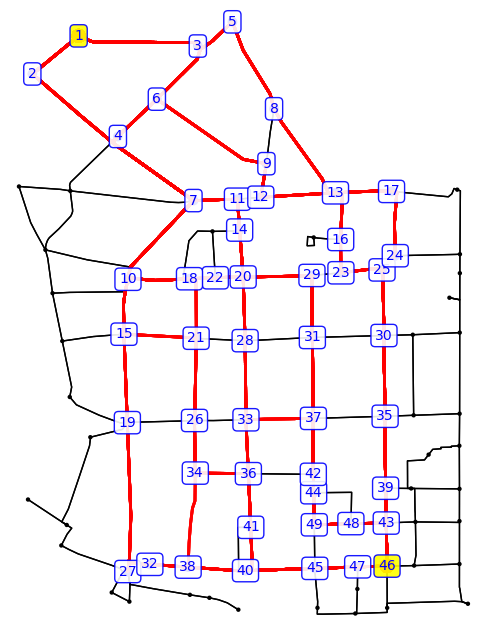

In [25]:


# Add the node numbers to the plot
fig, ax = ox.plot_graph_routes(
    G, 
    fair_fp, 
    route_linewidths=2, 
    node_size=node_sizes, 
    bgcolor='white', 
    edge_color='black', 
    node_color=node_colors,
    show=False,
    close=False,
)

# Annotate the node numbers
for node in dag_nodes:
    x, y = G.nodes[node]['x'], G.nodes[node]['y']  # Get node coordinates
    if node == orig_node or node == dest_node:
        ax.annotate(
        str(node_mapping[node]), 
        (x, y), 
        fontsize=10, 
        color='blue', 
        ha='center', 
        va='center',
        bbox=dict(boxstyle="round,pad=0.3", edgecolor='blue', facecolor='yellow', alpha=0.9)
    )
    else:
        ax.annotate(
            str(node_mapping[node]), 
            (x, y), 
            fontsize=10, 
            color='blue', 
            ha='center', 
            va='center',
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='blue', facecolor='white', alpha=0.9)
        )




#plt.savefig("../FairShortPath/plot_paths_example_florence/dag_numbered_florence.jpg", bbox_inches="tight")

plt.show()


In [26]:
fair_fp = ut.sample_k_FP(LP_dag, orig_node, dest_node, 10000)

In [27]:
my_paths = [[node_mapping[y] for y in x] for x in fair_fp]

In [28]:
path_counts = {}
for path in my_paths:
    path_tuple = tuple(path)  # Convert the path to a tuple for hashing
    if path_tuple in path_counts:
        path_counts[path_tuple] += 1
    else:
        path_counts[path_tuple] = 1
path_counts

{(1, 2, 4, 7, 10, 15, 19, 27, 32, 38, 40, 45, 47, 46): 1073,
 (1, 2, 4, 7, 10, 18, 22, 20, 28, 33, 37, 42, 44, 49, 48, 43, 46): 191,
 (1, 3, 6, 9, 12, 13, 17, 24, 25, 30, 35, 39, 43, 46): 841,
 (1, 2, 4, 7, 10, 15, 21, 26, 34, 36, 41, 40, 45, 47, 46): 347,
 (1, 3, 6, 4, 7, 10, 15, 19, 27, 32, 38, 40, 45, 47, 46): 624,
 (1, 3, 5, 8, 13, 17, 24, 25, 30, 35, 39, 43, 46): 787,
 (1, 2, 4, 7, 11, 14, 20, 29, 31, 37, 42, 44, 49, 48, 43, 46): 519,
 (1, 2, 4, 7, 10, 18, 21, 26, 34, 36, 41, 40, 45, 47, 46): 323,
 (1, 3, 6, 4, 7, 10, 18, 22, 20, 29, 31, 37, 42, 44, 49, 48, 43, 46): 317,
 (1, 3, 6, 4, 7, 11, 14, 20, 29, 31, 37, 42, 44, 49, 48, 43, 46): 298,
 (1, 2, 4, 7, 10, 18, 22, 20, 29, 31, 37, 42, 44, 49, 48, 43, 46): 527,
 (1, 3, 6, 9, 12, 13, 16, 23, 25, 30, 35, 39, 43, 46): 835,
 (1, 2, 4, 7, 10, 18, 22, 20, 28, 33, 36, 41, 40, 45, 47, 46): 359,
 (1, 3, 6, 4, 7, 10, 15, 21, 26, 34, 38, 40, 45, 47, 46): 99,
 (1, 3, 6, 4, 7, 10, 15, 21, 26, 34, 36, 41, 40, 45, 47, 46): 210,
 (1, 2, 4, 7, 11,

In [29]:
def find_paths(dag, s, t, path=[]):
    """
    Helper function to find all paths from s to t.
    Uses depth-first search (DFS) to explore paths.
    """
    path = path + [s]
    if s == t:
        return [path]
    if s not in dag:
        return []
    paths = []
    for neighbor in dag.neighbors(s):
        if neighbor not in path:  # Avoid cycles
            new_paths = find_paths(dag, neighbor, t, path)
            for p in new_paths:
                paths.append(p)
    return paths

def compute_probabilities_and_expectations(dag, result, s, t):
    flow = result['flow']
    
    # Initialize node attributes
    for node in dag.nodes():
        out_edges = list(dag.out_edges(node, data=True))
        total_out_flow = sum(flow[u, v] for u, v, _ in out_edges)
        
        dag.nodes[node]['prob'] = total_out_flow
        
        for u, v, data in out_edges:
            flow_value = flow[u, v]
            data['prob'] = flow_value
            
            if total_out_flow > 0:
                data['cond_prob'] = flow_value / total_out_flow
            else:
                data['cond_prob'] = 0
    
    # Ensure the probability of the target node is set to 1
    dag.nodes[t]['prob'] = 1
    
    # Compute the expected length (edge weights) of a path
    edge_weights = np.array([data['length'] for u, v, data in dag.edges(data=True)])
    edge_probs = np.array([data['prob'] for u, v, data in dag.edges(data=True)])
    exp_length = (edge_weights * edge_probs).sum()
    
    # Compute the expected number of vertices visited in a path (including s and t)
    exp_numv = 1 + edge_probs.sum()
    
    # Find all paths from s to t
    paths = find_paths(dag, s, t)
    
    # Calculate the probability of each path
    path_probabilities = {}
    for path in paths:
        path_probability = 1
        for i in range(len(path) - 1):
            u, v = path[i], path[i+1]
            path_probability *= dag[u][v]['cond_prob']
        path_probabilities[tuple(path)] = path_probability
    
    return {
        "exp_length": exp_length,
        "exp_numv": exp_numv,
        "path_probabilities": path_probabilities
    }

# Usage:
# result is the dictionary with 'flow' that you already have.
# G is your graph, and s, t are the source and target nodes.
my_data = compute_probabilities_and_expectations(LP_dag, result, orig_node, dest_node)  
my_data['path_probabilities']

{(36, 37, 3, 0, 1, 34, 56, 31, 51, 52, 75, 43, 42, 18, 17): 0.0,
 (36, 37, 3, 0, 1, 34, 56, 31, 51, 52, 78, 41, 40, 42, 18, 17): 0.0,
 (36, 37, 3, 0, 1, 34, 56, 31, 51, 52, 78, 41, 40, 23, 20, 17): 0.0,
 (36, 37, 3, 0, 1, 34, 56, 31, 51, 52, 78, 41, 23, 20, 17): 0.0,
 (36, 37, 3, 0, 1, 34, 56, 31, 51, 53, 24, 21, 20, 17): 0.0,
 (36, 37, 3, 0, 1, 34, 56, 31, 51, 53, 78, 41, 40, 42, 18, 17): 0.0,
 (36, 37, 3, 0, 1, 34, 56, 31, 51, 53, 78, 41, 40, 23, 20, 17): 0.0,
 (36, 37, 3, 0, 1, 34, 56, 31, 51, 53, 78, 41, 23, 20, 17): 0.0,
 (36,
  37,
  3,
  0,
  1,
  34,
  56,
  31,
  74,
  52,
  75,
  43,
  42,
  18,
  17): 0.034722222222222265,
 (36, 37, 3, 0, 1, 34, 56, 31, 74, 52, 78, 41, 40, 42, 18, 17): 0.0,
 (36, 37, 3, 0, 1, 34, 56, 31, 74, 52, 78, 41, 40, 23, 20, 17): 0.0,
 (36, 37, 3, 0, 1, 34, 56, 31, 74, 52, 78, 41, 23, 20, 17): 0.0,
 (36, 37, 3, 0, 1, 34, 56, 31, 74, 73, 43, 42, 18, 17): 0.017361111111111088,
 (36, 37, 3, 0, 1, 34, 56, 54, 27, 26, 24, 21, 20, 17): 0.0,
 (36, 37, 3, 0, 

In [30]:
from tabulate import tabulate

def convert_to_ordered_probabilities_table(path_probabilities):
    # Filter out paths with zero probability
    non_zero_paths = {path: prob for path, prob in path_probabilities.items() if prob > 0}
    
    total_probability = sum(non_zero_paths.values())  # Calculate the total probability sum
    
    # Sort by probability in descending order
    ordered_probabilities = sorted(non_zero_paths.items(), key=lambda x: x[1], reverse=True)
    
    # Create a table with headers
    table = [["Path", "Probability (%)"]]
    for path, prob in ordered_probabilities:
        percentage = prob * 100  # Convert to percentage

        table.append([[node_mapping[y] for y in path], f"{percentage:.1f}"])  # Format percentage with 1 decimal place
    
    total_probability_before_rounding = sum(prob * 100 for prob in non_zero_paths.values())
    
    return tabulate(table, headers="firstrow", tablefmt="pretty"), total_probability_before_rounding

# Example usage:
# path_probabilities is the dictionary you obtained from compute_probabilities_and_expectations.
table, before_rounding = convert_to_ordered_probabilities_table(my_data['path_probabilities'])

print(table)
print(f"Sum of probabilities before rounding: {before_rounding:.6f}%")


+---------------------------------------------------------------------+-----------------+
|                                Path                                 | Probability (%) |
+---------------------------------------------------------------------+-----------------+
|        [1, 2, 4, 7, 10, 15, 19, 27, 32, 38, 40, 45, 47, 46]         |      10.4       |
|        [1, 3, 6, 9, 12, 13, 16, 23, 25, 30, 35, 39, 43, 46]         |       8.3       |
|          [1, 3, 5, 8, 13, 16, 23, 25, 30, 35, 39, 43, 46]           |       8.3       |
|        [1, 3, 6, 9, 12, 13, 17, 24, 25, 30, 35, 39, 43, 46]         |       8.3       |
|          [1, 3, 5, 8, 13, 17, 24, 25, 30, 35, 39, 43, 46]           |       8.3       |
|       [1, 3, 6, 4, 7, 10, 15, 19, 27, 32, 38, 40, 45, 47, 46]       |       6.3       |
|    [1, 2, 4, 7, 11, 14, 20, 29, 31, 37, 42, 44, 49, 48, 43, 46]     |       5.2       |
|  [1, 2, 4, 7, 10, 18, 22, 20, 29, 31, 37, 42, 44, 49, 48, 43, 46]   |       5.2       |
|      [1,

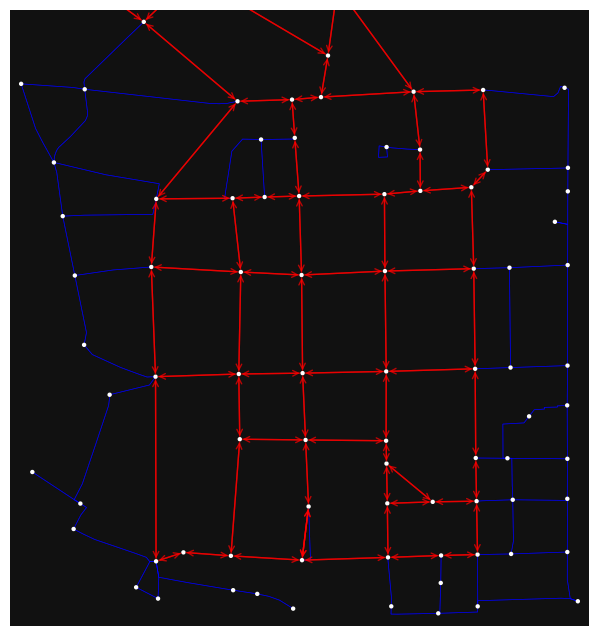

In [31]:
from matplotlib.patches import FancyArrowPatch

g1_filtered = G.copy()
g2 = dag.copy()
g2_edges = set(g2.edges())
g1_filtered.remove_edges_from(g2_edges)

# Plot g1 normally (without g2's edges)
fig, ax = ox.plot_graph(
    g1_filtered, 
    node_size=10, 
    edge_linewidth=0.5, 
    edge_color='blue', 
    edge_alpha=0.7,
    show=False  # Don't show yet, we'll add arrows for g2
)

# Add arrows for the edges in g2
for u, v, data in g2.edges(data=True):
    # Get the coordinates of the edge endpoints
    x_start, y_start = g2.nodes[u]['x'], g2.nodes[u]['y']
    x_end, y_end = g2.nodes[v]['x'], g2.nodes[v]['y']
    
    # Create an arrow for g2's edges
    arrow = FancyArrowPatch(
        (x_start, y_start), (x_end, y_end), 
        mutation_scale=10,  # Size of the arrow
        arrowstyle='->',    # Arrow style
        color='red',        # Color for g2 edges
        alpha=0.7           # Transparency
    )
    
    # Add the arrow to the plot
    ax.add_patch(arrow)

# Show the final plot
plt.show()

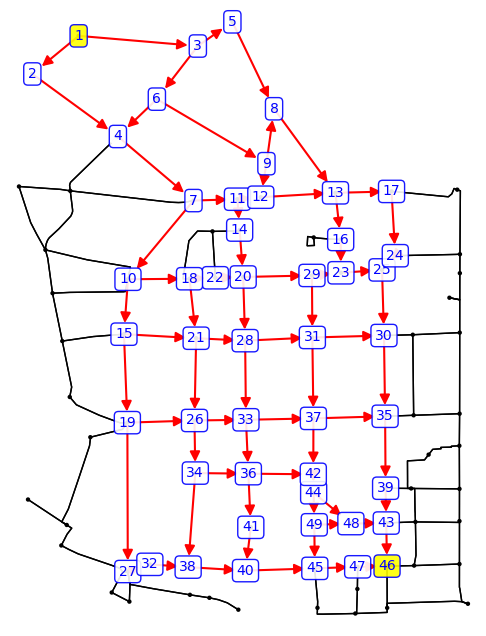

In [32]:
import osmnx as ox
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch

# Copy graphs
g1_filtered = G.copy()
g2 = LP_dag.copy()
g2 = g2.to_directed()
# Remove g2 edges from g1 to avoid duplicate edges

edge_colors = ['white' if (u, v) in g2_edges else 'black' for u, v in g1_filtered.edges()]

# Plot g1 normally (without g2's edges)
fig, ax = ox.plot_graph(
    g1_filtered, 
    node_size=10, 
    edge_linewidth=1, 
    bgcolor='white',
    node_color='black',
    edge_color=edge_colors, 
    show=False  # Don't show yet, we'll add arrows for g2
)


# Annotate the node numbers
for node in dag_nodes:
    x, y = G.nodes[node]['x'], G.nodes[node]['y']  # Get node coordinates
    if node == orig_node or node == dest_node:
        ax.annotate(
        str(node_mapping[node]), 
        (x, y), 
        fontsize=10, 
        color='blue', 
        ha='center', 
        va='center',
        bbox=dict(boxstyle="round,pad=0.3", edgecolor='blue', facecolor='yellow', alpha=0.9)
    )
    else:
        ax.annotate(
            str(node_mapping[node]), 
            (x, y), 
            fontsize=10, 
            color='blue', 
            ha='center', 
            va='center',
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='blue', facecolor='white', alpha=0.9)
        )




# Approximate bounding box size (adjust based on font and plot scale)
bbox_width = 7  # Horizontal padding of the text box
bbox_height = 8  # Vertical padding of the text box

for u, v in g2.edges():
    # Get start and end node positions
    x_start, y_start = g2.nodes[u]['x'], g2.nodes[u]['y']
    x_end, y_end = g2.nodes[v]['x'], g2.nodes[v]['y']

    # Compute direction vector
    dx, dy = x_end - x_start, y_end - y_start
    length = np.hypot(dx, dy)  # Get magnitude

    if length > 0:  
        # Normalize direction vector
        unit_dx, unit_dy = dx / length, dy / length

        # Determine the intersection point with the bounding box
        if abs(unit_dx) > abs(unit_dy):  # Horizontal intersection
            x_end_adj = x_end - np.sign(unit_dx) * bbox_width
            y_end_adj = y_end - unit_dy * (abs(x_end - x_end_adj) / abs(unit_dx))
        else:  # Vertical intersection
            y_end_adj = y_end - np.sign(unit_dy) * bbox_height
            x_end_adj = x_end - unit_dx * (abs(y_end - y_end_adj) / abs(unit_dy))
    else:
        x_end_adj, y_end_adj = x_end, y_end  # Avoid division by zero

    # Create the arrow
    arrow = FancyArrowPatch(
        (x_start, y_start), 
        (x_end_adj, y_end_adj),  
        mutation_scale=15,  
        arrowstyle='-|>',   
        color='red',        
        alpha=1,          
        linewidth=1.5
    )
    ax.add_patch(arrow)



# Show the final plot
plt.show()


In [33]:
LP_dag.edges(data = True)

OutEdgeDataView([(0, 1, {'osmid': 24582418, 'oneway': False, 'lanes': '1', 'name': 'Via dei Rondinelli', 'highway': 'residential', 'reversed': False, 'length': 100.10198066842088, 'geometry': <LINESTRING (6.81e+05 4.85e+06, 6.81e+05 4.85e+06, 6.81e+05 4.85e+06, 6.81e+...>, 'u_original': 249430055, 'v_original': 268628928, 'prob': 0.5, 'cond_prob': 0.75}), (0, 4, {'osmid': 183642246, 'oneway': False, 'name': 'Via dei Cerretani', 'highway': 'residential', 'reversed': True, 'length': 42.163, 'geometry': <LINESTRING (6.81e+05 4.85e+06, 6.81e+05 4.85e+06, 6.81e+05 4.85e+06, 6.81e+...>, 'access': 'no', 'u_original': 249430055, 'v_original': 249430056, 'prob': 0.16666666666666666, 'cond_prob': 0.25}), (1, 34, {'osmid': 38605304, 'oneway': False, 'name': 'Piazza degli Antinori', 'highway': 'pedestrian', 'reversed': True, 'length': 53.20959779787752, 'geometry': <LINESTRING (6.81e+05 4.85e+06, 6.81e+05 4.85e+06, 6.81e+05 4.85e+06, 6.81e+...>, 'u_original': 271777087, 'v_original': 267483190, 'p

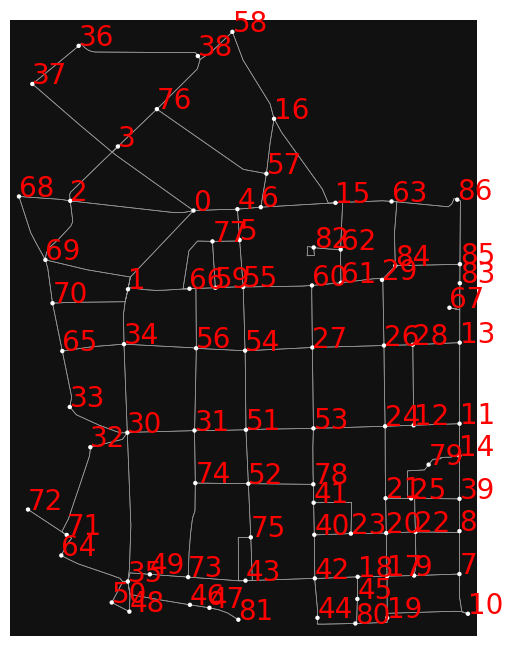

In [34]:
# Plot the graph
fig, ax = ox.plot_graph(G, node_size=10, edge_linewidth=0.5, show=False, close=False)

# Annotate each node with its ID
for node, data in G.nodes(data=True):
    x, y = data['x'], data['y']
    ax.text(x, y, str(node), fontsize=20, color='red')

plt.show()

In [35]:
# Create a subgraph SG based on a (possibly multigraph) G
SG = G.__class__()
l = [36, 37, 38, 58, 16, 57, 15, 6, 4, 0, 76, 3]
SG.add_nodes_from((n, G.nodes[n]) for n in l)

SG.add_edges_from(
    (n, nbr, d)
    for n, nbrs in G.adj.items()
    if n in l
    for nbr, d in nbrs.items()
    if nbr in l
)
SG.graph.update(G.graph)

In [36]:
# Create a subgraph SG based on a (possibly multigraph) G
lp_new = LP_dag.__class__()
l = [36, 37, 38, 58, 16, 57, 15, 6, 4, 0, 76, 3]
lp_new.add_nodes_from((n, LP_dag.nodes[n]) for n in l)

lp_new.add_edges_from(
    (n, nbr, d)
    for n, nbrs in LP_dag.adj.items()
    if n in l
    for nbr, d in nbrs.items()
    if nbr in l
)
lp_new.graph.update(LP_dag.graph)

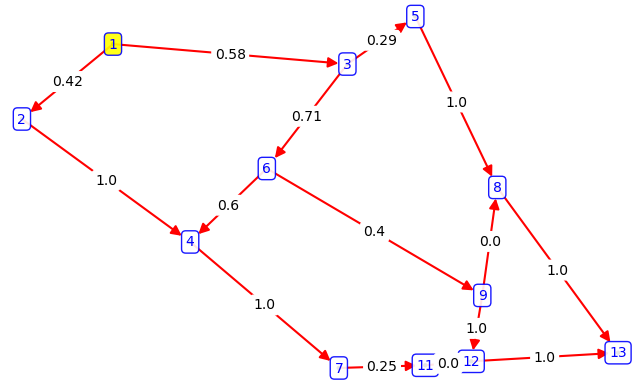

In [37]:

# Copy graphs
g_sub = SG.copy()
g2 = LP_dag.copy()
g2 = g2.to_directed()
# Remove g2 edges from g1 to avoid duplicate edges

edge_colors = ['white' if (u, v) in g2_edges else 'black' for u, v in g_sub.edges()]

# Plot g1 normally (without g2's edges)
fig, ax = ox.plot_graph(
    SG, 
    node_size=10, 
    edge_linewidth=1, 
    bgcolor='white',
    node_color='black',
    edge_color=edge_colors, 
    show=False  # Don't show yet, we'll add arrows for g2
)


# Annotate the node numbers
for node in SG.nodes():
    x, y = SG.nodes[node]['x'], G.nodes[node]['y']  # Get node coordinates
    if node == orig_node or node == dest_node:
        ax.annotate(
        str(node_mapping[node]), 
        (x, y), 
        fontsize=10, 
        color='blue', 
        ha='center', 
        va='center',
        bbox=dict(boxstyle="round,pad=0.3", edgecolor='blue', facecolor='yellow', alpha=0.9)
    )
    else:
        ax.annotate(
            str(node_mapping[node]), 
            (x, y), 
            fontsize=10, 
            color='blue', 
            ha='center', 
            va='center',
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='blue', facecolor='white', alpha=0.9)
        )




# Approximate bounding box size (adjust based on font and plot scale)
bbox_width = 3  # Horizontal padding of the text box
bbox_height = 4  # Vertical padding of the text box


for u, v, data in lp_new.edges(data=True):
    # Get edge weight (assuming weight is stored in data dictionary)
    weight = round(data.get('cond_prob', ''),2)  # Default to empty if no weight
    
    # Get start and end node positions
    x_start, y_start = lp_new.nodes[u]['x'], lp_new.nodes[u]['y']
    x_end, y_end = lp_new.nodes[v]['x'], lp_new.nodes[v]['y']

    # Compute direction vector
    dx, dy = x_end - x_start, y_end - y_start
    length = np.hypot(dx, dy)  # Get magnitude

    if length > 0:  
        # Normalize direction vector
        unit_dx, unit_dy = dx / length, dy / length

        # Determine the intersection point with the bounding box
        if abs(unit_dx) > abs(unit_dy):  # Horizontal intersection
            x_end_adj = x_end - np.sign(unit_dx) * bbox_width
            y_end_adj = y_end - unit_dy * (abs(x_end - x_end_adj) / abs(unit_dx))
        else:  # Vertical intersection
            y_end_adj = y_end - np.sign(unit_dy) * bbox_height
            x_end_adj = x_end - unit_dx * (abs(y_end - y_end_adj) / abs(unit_dy))
    else:
        x_end_adj, y_end_adj = x_end, y_end  # Avoid division by zero

    # Create the arrow
    arrow = FancyArrowPatch(
        (x_start, y_start), 
        (x_end_adj, y_end_adj),  
        mutation_scale=15,  
        arrowstyle='-|>',   
        color='red',        
        alpha=1,          
        linewidth=1.5
    )
    ax.add_patch(arrow)

    # Position the edge weight label near the middle of the edge
    mid_x = (x_start + x_end) / 2 
    mid_y = (y_start + y_end) / 2
    
    # Offset slightly along the perpendicular direction for clarity
    perp_dx = -unit_dy * 0  # Small perpendicular shift
    perp_dy = unit_dx * 0

    ax.text(
        mid_x + perp_dx, mid_y + perp_dy,  # Adjusted position
        str(weight), 
        fontsize=10, 
        color='black', 
        ha='center', 
        va='center',
        bbox=dict(boxstyle="round,pad=0.2", edgecolor='white', facecolor='white', alpha=1)
    )

In [38]:
LP_dag.edges(data = 'cond_prob')

OutEdgeDataView([(0, 1, 0.75), (0, 4, 0.25), (1, 34, 0.5), (1, 66, 0.5), (3, 0, 1.0), (4, 5, 1.0), (4, 6, 0.0), (5, 55, 1.0), (6, 15, 1.0), (15, 62, 0.5000000000000001), (15, 63, 0.49999999999999983), (16, 15, 1.0), (18, 17, 1.0), (20, 17, 1.0), (21, 20, 1.0), (23, 20, 1.0), (24, 21, 1.0), (26, 24, 1.0), (27, 26, 0.0), (27, 53, 1.0), (29, 26, 1.0), (30, 31, 0.0), (30, 35, 1.0), (31, 51, 0.0), (31, 74, 1.0), (34, 56, 0.3333333333333334), (34, 30, 0.6666666666666666), (35, 49, 1.0), (36, 37, 0.41666666666666674), (36, 38, 0.5833333333333333), (37, 3, 1.0), (38, 76, 0.7142857142857144), (38, 58, 0.2857142857142857), (40, 42, 0.0), (40, 23, 1.0), (41, 40, 1.0), (41, 23, 0.0), (42, 18, 1.0), (43, 42, 1.0), (49, 73, 1.0), (51, 52, 0.6666666666666664), (51, 53, 0.33333333333333354), (52, 75, 1.0), (52, 78, 0.0), (53, 24, 0.0), (53, 78, 1.0), (54, 27, 0.0), (54, 51, 1.0), (55, 54, 0.5), (55, 60, 0.5), (56, 31, 1.0), (56, 54, 0.0), (57, 16, 0.0), (57, 6, 1.0), (58, 16, 1.0), (59, 55, 1.0), (60,

In [39]:
lp_new.edges(data = 'cond_prob')

OutEdgeDataView([(36, 37, 0.41666666666666674), (36, 38, 0.5833333333333333), (37, 3, 1.0), (38, 76, 0.7142857142857144), (38, 58, 0.2857142857142857), (58, 16, 1.0), (16, 15, 1.0), (57, 16, 0.0), (57, 6, 1.0), (6, 15, 1.0), (4, 6, 0.0), (0, 4, 0.25), (76, 3, 0.6000000000000001), (76, 57, 0.4), (3, 0, 1.0)])